In [1]:
using LinearAlgebra
using PlotlyJS

include("hubbard_core.jl")

no_particles_from_state (generic function with 1 method)

In [2]:
t = 1
U = 1

const N = 2
const states = reshape(Iterators.product([[0,1] for _ in 1:2N]...) .|> collect, (1, 2^(2N)))
const next = [collect(2:N); 1]

2-element Vector{Int64}:
 2
 1

## Zależność od potencjału chemicznego w T=0K

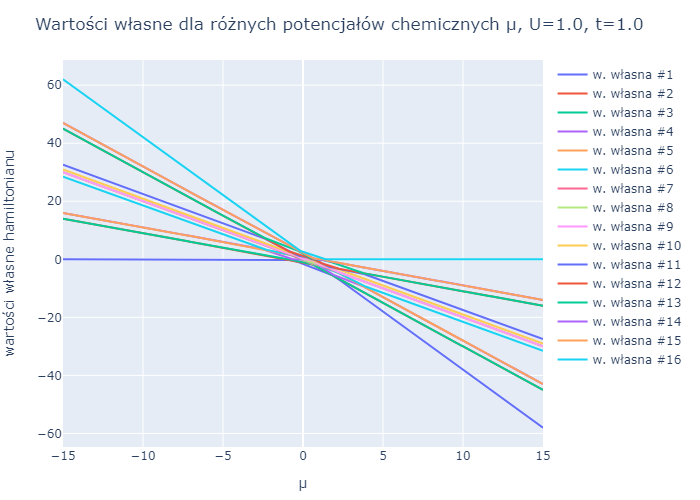

In [14]:
pot_max = 15
pot_step = 0.05
potentials = collect(-pot_max:pot_step:pot_max)
data = [eigen(get_hamiltonian(states, U, t, pot, next, N)) for pot in potentials]
eigs_mat_orig = reduce(hcat,[real(d.values) for d in data])'
eigvecs = [real(d.vectors) for d in data]
eigs_mat = [eigs_mat_orig[:,i] for i in 1:size(eigs_mat_orig,2)]
layout = Layout(
    title="Wartości własne dla różnych potencjałów chemicznych μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="wartości własne hamiltonianu",
)
pl = plot([scatter(x=potentials, y=eig, name="w. własna #$no") for (eig, no) in zip(eigs_mat, 1:(2N)^2)], layout)

In [ ]:
[real(d.vectors)[:,1] for d in data][523]

Wybieramy stany o najmniejszej energii (dolna krawędź powyższego wykresu):

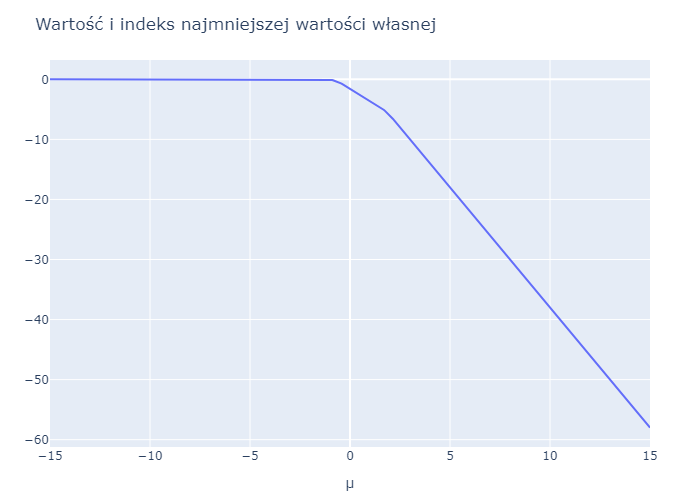

In [15]:
ground_energies = [findmin(eigs_mat_orig[i,:]) for i in 1:size(potentials,1)]
ground_energies = [g[1] for g in ground_energies]
# all_states = [real(eigvecs(get_hamiltonian(states, U, t, pot, next, N))) for pot in potentials]
ground_states = [real(d.vectors)[:,1] for d in data][1]

layout = Layout(
    title="Wartość i indeks najmniejszej wartości własnej",
    xaxis_title="μ",
)
plot(scatter(x=potentials, y=[g for g in ground_energies], name="Wartość"), layout)

Wartości własne zwizualizowane:

In [ ]:
# plot([scatter(x=1:16, y=real(data[1].vectors)[1,i]) for i in 1:16])
# plot([scatter(x=1:16, y=real(eigvecs)[1,i]) for i in 1:16])
eigval_idx = 1
eigenvals_sorted = [[eigvecs[pot][:,eigval_idx][eigv] for pot in 1:601] for eigv in 1:16]
plot([scatter(x=potentials, y=tt, name=reduce(*, string.(statename))) for (tt, statename) in zip(eigenvals_sorted, states)])


Średnia ilość cząstek w stanie, w zależności od potencjału chemicznego:

In [ ]:
avg_no_particles = [[no_particles_from_state(state, N) for state in 
    [states_row[:, i] for states_row in eigvecs]] for i in 1:2^(2N)]

layout = Layout(
    title="Średnia ilość cząstek w funkcji potencjału chemicznego μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="Średnia ilość cząstek",
)
plot([scatter(x=potentials, y=avg_no_particles[1])], layout)

## Zależność temperaturowa

In [3]:
U = 1.0
t = 1.0
k = 1.0

function compute_thermodynamic_quantities(chem_pot, temperature, U, t, next, states)
    N = Int(length(states[1])//2)
    H_matrix = get_hamiltonian(states, U, t, chem_pot, next, N)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = diagonalized.vectors
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    avg_particles = [no_particles_from_state(H_states[:, i], N) for i in 1:(2N)^2]
    
    densities = exp_vec ./ stat_sum
    avg_particles_temp = reduce(+, densities .* avg_particles)
    entropy = -k * reduce(+, [abs(p)*log(abs(p)) for p in densities])
    grand_potential = -k*temperature*log(stat_sum)
    return densities, avg_particles_temp, entropy, grand_potential
end

chem_potentials = -2.5:0.01:2.5
temp_range = round.(10.0.^(range(-1.5,stop=-0.5,length=5)), digits=3)

thermodynamics = [[compute_thermodynamic_quantities(chem_pot, temperature, U, t, next, states)
        for chem_pot in chem_potentials] for temperature in temp_range]

avg_n = [[thermodynamics[j][i][2] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]
entropy_vals = [[thermodynamics[j][i][3] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]
grand_pots = [[thermodynamics[j][i][4] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]

helmholtz_vals = [[grand_pot + chem_pot*avg_no for (grand_pot, chem_pot, avg_no) in zip(grand_pot_rows, chem_potentials, avg_no_rows)] 
    for (grand_pot_rows, temp, avg_no_rows) in zip(grand_pots, temp_range, avg_n)]

U_vals = [[helm + entr*temp for (pot, helm, entr) in zip(chem_potentials, helmholtz_vals_rows, entr_rows)]
     for (temp, helmholtz_vals_rows, entr_rows) in zip(temp_range, helmholtz_vals, entropy_vals)]

5-element Vector{Vector{Float64}}:
 [-8.779628840261076e-21, -1.2000329808293725e-20, -1.640250608857418e-20, -2.241956765219741e-20, -3.064391569173572e-20, -4.188526663359668e-20, -5.725037161097403e-20, -7.825198006418536e-20, -1.069577753237056e-19, -1.4619394541596786e-19  …  1.999989094148654, 1.9999920210970294, 1.9999941625036357, 1.9999957291930786, 1.9999968754091193, 1.9999977139995186, 1.9999983275258078, 1.999998776391466, 1.999999104788728, 1.9999993450493616]
 [-4.657384436169675e-12, -5.567941627106567e-12, -6.656520282520312e-12, -7.957925071606963e-12, -9.513765264351508e-12, -1.1373785087282453e-11, -1.3597454174779442e-11, -1.625586896677863e-11, -1.9434025845445133e-11, -2.3233538688888642e-11  …  1.9973586246629733, 1.9977901066012127, 1.9981511690277471, 1.9984532850984256, 1.998706064574263, 1.998917554695508, 1.9990944930066799, 1.9992425196451484, 1.9993663554802628, 1.9994699515178551]
 [-6.118042672551351e-7, -6.761482404373399e-7, -7.47259318762659e-7, -8.2

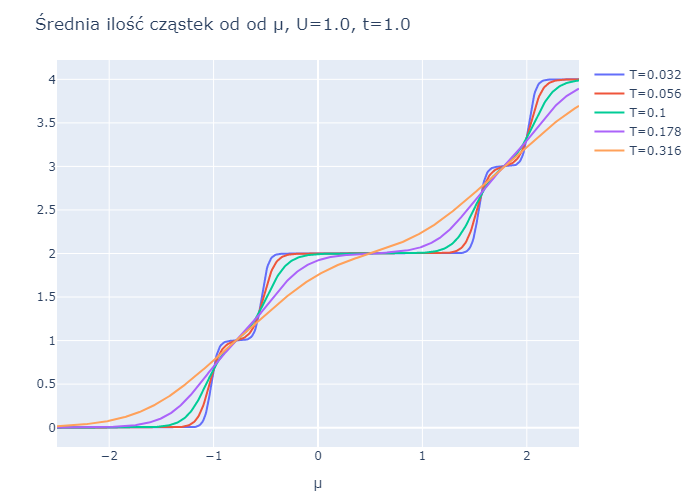

In [9]:
y_vals = avg_n

layout = Layout(
    title="Średnia ilość cząstek od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

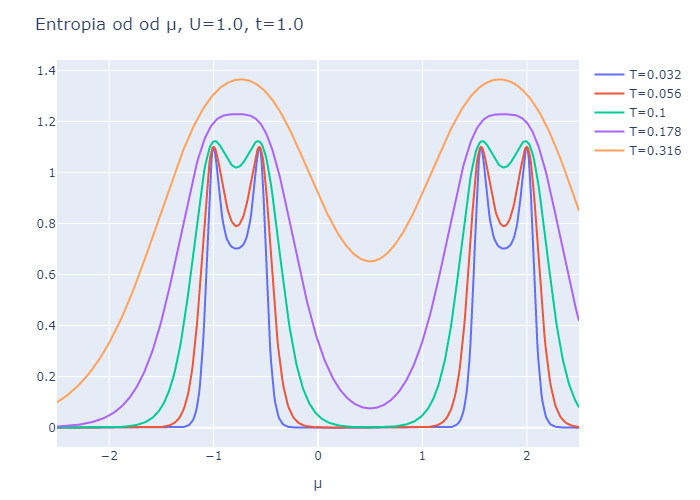

In [10]:
y_vals = entropy_vals

layout = Layout(
    title="Entropia od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

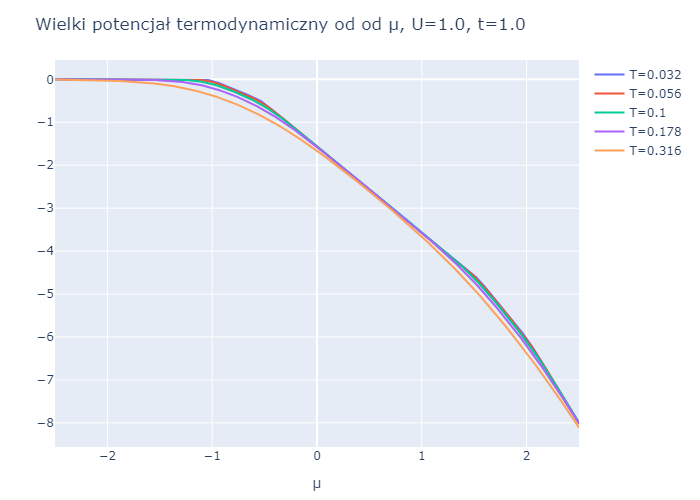

In [13]:
y_vals = grand_pots

layout = Layout(
    title="Wielki potencjał termodynamiczny od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

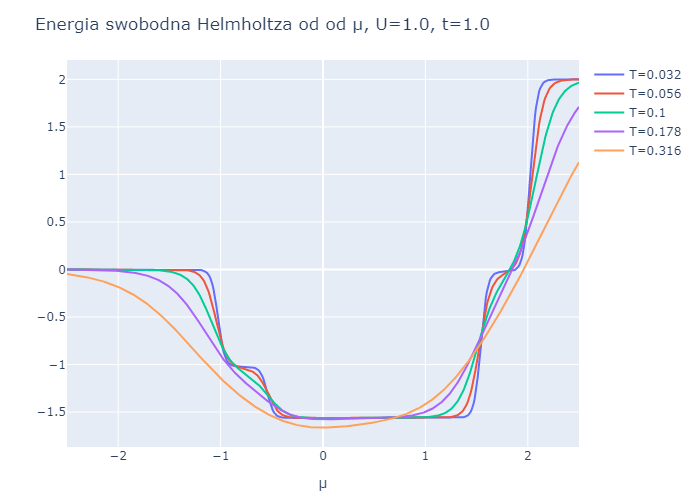

In [11]:
y_vals = helmholtz_vals

layout = Layout(
    title="Energia swobodna Helmholtza od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

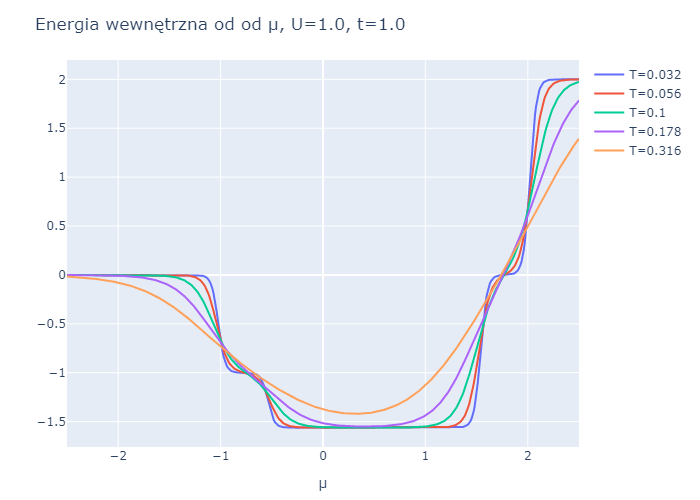

In [12]:
y_vals = U_vals

layout = Layout(
    title="Energia wewnętrzna od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)